In [3]:
import sys
import time
from os import listdir
import gzip

from collections import Counter
from itertools import chain, product

import numpy as np
from scipy import sparse

# Run locally with python3 phase_chromosome2.py 22 data/v34.forCompoundHet.ped split_gen

chrom = '22'
family_size = 5
ped_file = 'data/v34.forCompoundHet.ped'
data_dir = 'split_gen'
sample_file = '%s/chr.%s.gen.samples.txt' % (data_dir, chrom)
variant_file = '%s/chr.%s.gen.variants.txt.gz' % (data_dir, chrom)

# constants
g_neighbors = {0: [1, -1],
	           1: [0, 2, -1],
	           2: [1, -1],
	          -1: [0, 1, 2]}

g_equivalents = {0: [0, -1],
	             1: [1, -1],
	             2: [2, -1],
	            -1: [-1]}

# ancestral_variants (m1, m2, p1, p2)
anc_variants = np.array(list(product(*[[0, 1]]*4)), dtype=np.int8)
anc_variant_to_index = dict([(tuple(x), i) for i, x in enumerate(anc_variants)])
print('ancestral variants', anc_variants.shape)

# pull families with sequence data
with open(sample_file, 'r') as f:
	sample_ids = [line.strip() for line in f]
sample_id_to_index = dict([(sample_id, i) for i, sample_id in enumerate(sample_ids)])

families = dict()
with open(ped_file, 'r') as f:
    for line in f:
        pieces = line.strip().split('\t')
        fam_id, child_id, f_id, m_id = pieces[0:4]

        if child_id in sample_ids and f_id in sample_ids and m_id in sample_ids:
        	if (fam_id, m_id, f_id) not in families:
        		families[(fam_id, m_id, f_id)] = [m_id, f_id]
        	families[(fam_id, m_id, f_id)].append(child_id)

#families = dict(list(families.items())[:10])
family_to_indices = dict([(fid, [sample_id_to_index[x] for x in vs]) for fid, vs in families.items()])
family_to_index = dict([(fid, i) for i, fid in enumerate(families.keys())])

print('families with sequence data', len(families))
print('family sizes', Counter([len(x) for x in families.values()]))

# pull family sizes if family size is not given
if family_size == -1:
	family_sizes = sorted(set([len(x) for x in families.values()]))
else:
	family_sizes = [family_size]

# pull genotype data from .npz
gen_files = sorted([f for f in listdir('split_gen') if ('chr.%s' % chrom) in f and 'gen.npz' in f])
whole_chrom = sparse.hstack([sparse.load_npz('split_gen/%s' % gen_file) for gen_file in gen_files]).tocsr()
m, n = whole_chrom.shape
print('chrom shape', m, n, type(whole_chrom))

# discard variants that aren't SNPs
snp_indices = []
snp_positions = []
with gzip.open(variant_file, 'rt') as f:
    for i, line in enumerate(f):
        pieces = line.strip().split('\t')
        if len(pieces[3]) == 1 and len(pieces[4]) == 1 and pieces[3] != '.' and pieces[4] != '.':
            snp_indices.append(i)
            snp_positions.append(int(pieces[1]))
whole_chrom = whole_chrom[:, snp_indices]
snp_positions = np.array(snp_positions)
m, n = whole_chrom.shape
print('chrom shape only SNPs', m, n)

m = 5

inheritance_states = np.array(list(product(*[[0, 1]]*(2*m))), dtype=np.int8)
state_to_index = dict([(tuple(x), i) for i, x in enumerate(inheritance_states)])
p = inheritance_states.shape[0]
print('inheritance states', inheritance_states.shape)

# genotypes
genotypes = np.array(list(product(*[[-1, 0, 1, 2]]*m)), dtype=np.int8)
genotype_to_index = dict([(tuple(x), i) for i, x in enumerate(genotypes)])
q = genotypes.shape[0]
print('genotypes', genotypes.shape)

# map genotypes to neighbors and equivalents
genotype_to_neighbors = []
genotype_to_equivalents = []
for g in genotypes:
    neighbor_gs = []
    for j in range(m):
        for new_entry in g_neighbors[g[j]]:
            new_genotype = tuple(new_entry if k == j else x for k, x in enumerate(g))
            neighbor_gs.append(genotype_to_index[new_genotype])
    genotype_to_neighbors.append(neighbor_gs)   
    genotype_to_equivalents.append([genotype_to_index[tuple(x)] for x in product(*[g_equivalents[x] for x in g])]) 

print('genotype to equivalents', Counter([len(x) for x in genotype_to_equivalents]))    
print('genotype to neighbors', Counter([len(x) for x in genotype_to_neighbors]))

ancestral variants (16, 4)
families with sequence data 772
family sizes Counter({4: 401, 5: 294, 6: 48, 3: 17, 7: 6, 9: 3, 8: 2, 10: 1})
chrom shape 4610 1096535 <class 'scipy.sparse.csr.csr_matrix'>
chrom shape only SNPs 4610 1004649
inheritance states (1024, 10)
genotypes (1024, 5)
genotype to equivalents Counter({16: 405, 8: 270, 32: 243, 4: 90, 2: 15, 1: 1})
genotype to neighbors Counter({13: 320, 12: 320, 14: 160, 11: 160, 15: 32, 10: 32})


In [18]:
# loss matrix
losses = np.zeros((p, q), dtype=np.int8) - 1
for i, s in enumerate(inheritance_states):
	is_deletion = np.sum(s[:4]) > 0

	# what genotypes can be validly produced from this inheritance state?          
	valid_genotypes = np.zeros((anc_variants.shape[0], m), dtype=np.int8)

	# mom
	if s[0] == 0 and s[1] == 0:
		valid_genotypes[:, 0] = anc_variants[:, 0] + anc_variants[:, 1]
	elif s[0] == 0:
		valid_genotypes[:, 0] = 2*anc_variants[:, 0]
	elif s[1] == 0:
		valid_genotypes[:, 0] = 2*anc_variants[:, 1]
	else:
		valid_genotypes[:, 0] = -1
            
	# dad
	if s[2] == 0 and s[3] == 0:
		valid_genotypes[:, 1] = anc_variants[:, 2] + anc_variants[:, 3]
	elif s[2] == 0:
		valid_genotypes[:, 1] = 2*anc_variants[:, 2]
	elif s[3] == 0:
		valid_genotypes[:, 1] = 2*anc_variants[:, 3]
	else:
		valid_genotypes[:, 1] = -1
      
	# children
	for index in range(m-2):
		mat, pat = s[(4+(2*index)):(6+(2*index))]

		if s[mat] == 0 and s[2+pat] == 0:
			valid_genotypes[:, 2+index] = anc_variants[:, mat] + anc_variants[:, 2+pat]
		elif s[mat] == 0:
			valid_genotypes[:, 2+index] = 2*anc_variants[:, mat]
		elif s[2+pat] == 0:
			valid_genotypes[:, 2+index] = 2*anc_variants[:, 2+pat]
		else:
			valid_genotypes[:, 2+index] = -1

	valid_genotypes = set([genotype_to_index[tuple(x)] for x in valid_genotypes]) 

	# breadth first search to fill in loss for this state
	current_cost = 0
	while len(valid_genotypes) > 0:
		# add equivalents
		#if not is_deletion:
		valid_genotypes = valid_genotypes | set(chain.from_iterable([genotype_to_equivalents[x] for x in valid_genotypes]))

		next_gen = set()
		for g in valid_genotypes:
			# fill in loss matrix
			if losses[i, g] == -1:
				losses[i, g] = current_cost

				# pull next generation
				next_gen.update([ng for ng in genotype_to_neighbors[g] if losses[i, ng] == -1])

		valid_genotypes = next_gen
		current_cost += 1  	    

old_losses = losses
# Check if we've missed some
print('losses', losses.shape, 'missing', np.sum(losses == -1)/(losses.shape[0]*losses.shape[1]))

losses (1024, 1024) missing 0.0


In [26]:
# genotype (pred, obs): cost
g_cost = {
	(-1, -1): 0,
	(-1, 0): 1,
	(-1, 1): 1,
	(-1, 2): 1,
	(0, -1): 0,
	(0, 0): 0,
	(0, 1): 1,
	(0, 2): 2,
	(1, -1): 0,
	(1, 0): 1,
	(1, 1): 0,
	(1, 2): 1,
	(2, -1): 0,
	(2, 0): 2,
	(2, 1): 1,
	(2, 2): 0
}

# loss matrix
losses = np.zeros((p, q), dtype=np.int16)
for i, s in enumerate(inheritance_states):
	state_losses = np.zeros((q, anc_variants.shape[0]), dtype=np.int16)

	# mom
	if s[0] == 0 and s[1] == 0:
		pred_gens = anc_variants[:, 0] + anc_variants[:, 1]
	elif s[0] == 0:
		pred_gens = 2*anc_variants[:, 0]
	elif s[1] == 0:
		pred_gens = 2*anc_variants[:, 1]
	else:
		pred_gens = -1*np.ones((anc_variants.shape[0],))
	for obs_gen in [-1, 0, 1, 2]:
		state_losses[genotypes[:, 0]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]
        
	# dad
	if s[2] == 0 and s[3] == 0:
		pred_gens = anc_variants[:, 2] + anc_variants[:, 3]
	elif s[2] == 0:
		pred_gens = 2*anc_variants[:, 2]
	elif s[3] == 0:
		pred_gens = 2*anc_variants[:, 3]
	else:
		pred_gens = -1*np.ones((anc_variants.shape[0],))
	for obs_gen in [-1, 0, 1, 2]:
		state_losses[genotypes[:, 1]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]
      
	# children
	for index in range(m-2):
		mat, pat = s[(4+(2*index)):(6+(2*index))]

		if s[mat] == 0 and s[2+pat] == 0:
			pred_gens = anc_variants[:, mat] + anc_variants[:, 2+pat]
		elif s[mat] == 0:
			pred_gens = 2*anc_variants[:, mat]
		elif s[2+pat] == 0:
			pred_gens = 2*anc_variants[:, 2+pat]
		else:
			pred_gens = -1*np.ones((anc_variants.shape[0],))
		for obs_gen in [-1, 0, 1, 2]:
			state_losses[genotypes[:, 2+index]==obs_gen, :] += [g_cost[(pred_gen, obs_gen)] for pred_gen in pred_gens]

	losses[i, :] = np.min(state_losses, axis=1)

new_losses = losses
print('losses', losses.shape, losses)

losses (1024, 1024) [[0 0 0 ..., 2 1 0]
 [0 0 0 ..., 2 1 0]
 [0 0 0 ..., 2 1 0]
 ..., 
 [0 1 1 ..., 5 5 5]
 [0 1 1 ..., 5 5 5]
 [0 1 1 ..., 5 5 5]]


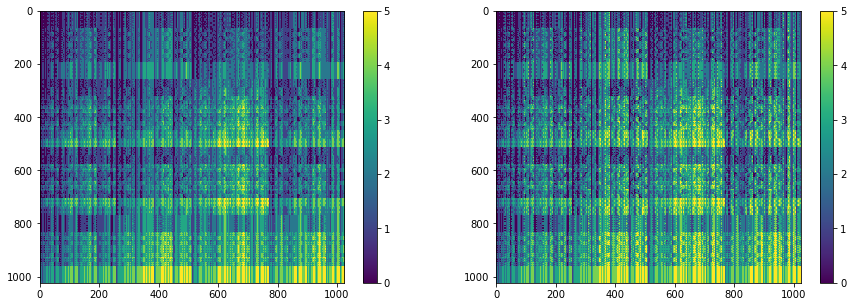

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.imshow(old_losses, aspect='auto')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(new_losses, aspect='auto')
plt.colorbar()
plt.show()

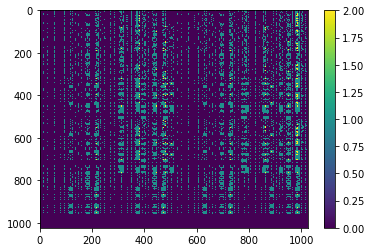

In [29]:
plt.imshow(new_losses-old_losses, aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
print(np.unique(new_losses[old_losses==0]-old_losses[old_losses==0], return_counts=True))